# Multivariate Survival Analysis

In the simplest form, for a defined unit of analysis, survival analysis seeks to understand the time it takes that unit to reach a specified event using only the time and an indicator of whether the event happened or not. This understanding crystallizes as a survival function $S(t)$. Since nothing other than time is used, these simple forms of analyses are called univarite analysis. The [Kaplan-Meier estimator](https://en.wikipedia.org/wiki/Kaplan%E2%80%93Meier_estimator) is one of the most used and well understood univariate estimator. However, when it is desired to use other additional variables to model the survival function, a regression approach known as the [Cox-Proportional Hazard](https://en.wikipedia.org/wiki/Proportional_hazards_model) `CPH` model (Cox regression) is typically used. Other regression techniques like [linear regression](https://en.wikipedia.org/wiki/Linear_regression) cannot be used since there is censoring involved with survival data. Advanced and modern methods go beyond Cox regression and use [ensemble techniques](https://scikit-survival.readthedocs.io/en/stable/index.html). Moreover, [deep learning](https://github.com/jaredleekatzman/DeepSurv) has also been applied to multivariate survival analysis.

One should wonder what these survival models are predicting. In the case of typical regression, a scalar is the model's predictive output. On the other hand, for survival regressions, $S(t)$ is the predictive output. If you remember, $S(t)$ is the probability of surviving pass time $t$ given that you have survived up to $t$ and denoted as $P(T > t)$. Since the predictive outputs of regression and survival regression are different and there is censoring involved, performance measures of survival regression are different from other types of regression. For regression models, the mean absolute error `MAE` or root mean squared error `RMSE` are commonly used. On the other hand, for survival regression models, the [concordance-index](https://square.github.io/pysurvival/metrics/c_index.html) (c-index) is recommended. 

In this notebook, we will look at a few available APIs in Python that may be used for multivariate survival modeling. 

- [lifelines](https://lifelines.readthedocs.io/en/latest/lifelines.datasets.html)
- [scikit-survival](https://scikit-survival.readthedocs.io/en/stable/index.html#)
- [PySurvival](https://square.github.io/pysurvival/)

## Load data

In [30]:
from lifelines.datasets import load_dd

df = load_dd()[['un_region_name', 'democracy', 'regime', 'duration', 'observed']] \
    .assign(
        un_region_name=lambda d: d['un_region_name'].apply(lambda s: s.lower().replace(' ', '_').replace('-', '')),
        democracy=lambda d: d['democracy'].apply(lambda s: 1 if s == 'Democracy' else 0),
        regime=lambda d: d['regime'].apply(lambda s: s.lower().replace(' ', '_'))
    ) \
    .rename(columns={
        'un_region_name': 'region',
        'duration': 'T',
        'observed': 'E'
    })

df.shape

(1808, 5)

In [31]:
df.dtypes

region       object
democracy     int64
regime       object
T             int64
E             int64
dtype: object

In [32]:
df.head()

,region,democracy,regime,T,E
0,southern_asia,0,monarchy,7,1
1,southern_asia,0,civilian_dict,10,1
2,southern_asia,0,monarchy,10,1
3,southern_asia,0,civilian_dict,5,0
4,southern_asia,0,civilian_dict,1,0


In [33]:
df['region'].value_counts()

south_america                191
western_europe               164
southern_europe              161
northern_europe              148
western_asia                 142
western_africa               118
central_america              113
eastern_europe               103
southern_asia                 98
eastern_africa                91
caribbean                     86
southeastern_asia             81
eastern_asia                  68
middle_africa                 51
melanesia                     36
micronesia                    31
northern_africa               29
australia_and_new_zealand     25
southern_africa               25
northern_america              22
polynesia                     16
central_asia                   9
Name: region, dtype: int64

In [34]:
df['democracy'].value_counts()

1    1187
0     621
Name: democracy, dtype: int64

In [35]:
df['regime'].value_counts()

parliamentary_dem    585
civilian_dict        330
presidential_dem     327
mixed_dem            275
military_dict        236
monarchy              55
Name: regime, dtype: int64

## lifelines

In [39]:
import pandas as pd

Xy = pd.get_dummies(df) \
    .drop(columns=['region_central_asia', 'regime_monarchy'])
Xy.shape

(1808, 29)

In [41]:
X = Xy[Xy.columns.drop(['T'])]
y = Xy['T']

X.shape, y.shape

((1808, 28), (1808,))

In [113]:
from lifelines.utils.sklearn_adapter import sklearn_adapter
from lifelines import CoxPHFitter, LogLogisticAFTFitter, WeibullAFTFitter, LogNormalAFTFitter

CoxRegression = sklearn_adapter(CoxPHFitter, event_col='E')
LogLogisticRegression = sklearn_adapter(LogLogisticAFTFitter, event_col='E')
WeibullRegression = sklearn_adapter(WeibullAFTFitter, event_col='E')
LogNormalRegression = sklearn_adapter(LogNormalAFTFitter, event_col='E')

cph = CoxRegression(penalizer=1e-5)
lla = LogLogisticRegression(penalizer=1e-5)
waf = WeibullRegression(penalizer=1e-5)
lna = LogNormalRegression(penalizer=1e-5)

cph.fit(X, y)
lla.fit(X, y)
waf.fit(X, y)
lna.fit(X, y)

SkLearnLogNormalAFTFitter(alpha=0.05, fit_intercept=True, l1_ratio=0.0,
                          model_ancillary=False, penalizer=1e-05)

In [114]:
pd.Series(
    [cph.score(X, y), lla.score(X, y), waf.score(X, y), lna.score(X, y)], 
    index=['CoxPHFitter', 'LogLogisticAFTFitter', 'WeibullAFTFitter', 'LogNormalAFTFitter']
)

CoxPHFitter             0.647557
LogLogisticAFTFitter    0.669827
WeibullAFTFitter        0.639399
LogNormalAFTFitter      0.662717
dtype: float64

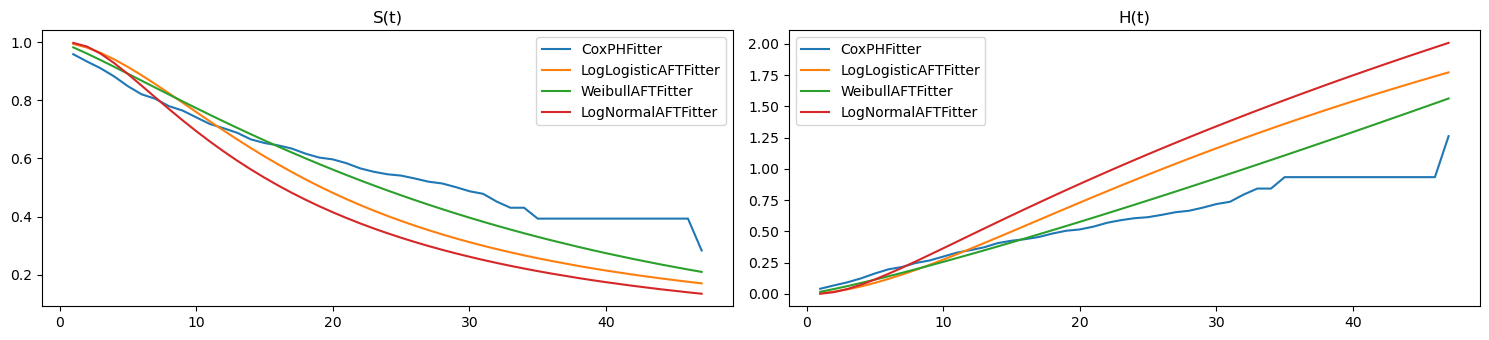

In [111]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(15, 3.5))

cph.lifelines_model.predict_survival_function(X)[[0]] \
    .rename(columns={0: 'CoxPHFitter'}) \
    .join(lla.lifelines_model.predict_survival_function(X)[[0]].rename(columns={0: 'LogLogisticAFTFitter'})) \
    .join(waf.lifelines_model.predict_survival_function(X)[[0]].rename(columns={0: 'WeibullAFTFitter'})) \
    .join(lna.lifelines_model.predict_survival_function(X)[[0]].rename(columns={0: 'LogNormalAFTFitter'})) \
    .plot(kind='line', ax=ax[0])

cph.lifelines_model.predict_cumulative_hazard(X)[[0]] \
    .rename(columns={0: 'CoxPHFitter'}) \
    .join(lla.lifelines_model.predict_cumulative_hazard(X)[[0]].rename(columns={0: 'LogLogisticAFTFitter'})) \
    .join(waf.lifelines_model.predict_cumulative_hazard(X)[[0]].rename(columns={0: 'WeibullAFTFitter'})) \
    .join(lna.lifelines_model.predict_cumulative_hazard(X)[[0]].rename(columns={0: 'LogNormalAFTFitter'})) \
    .plot(kind='line', ax=ax[1])

ax[0].set_title('S(t)')
ax[1].set_title('H(t)')

plt.tight_layout()

## scikit-survival

In [176]:
import numpy as np

X = Xy[Xy.columns.drop(['T', 'E'])] \
    .assign(democracy=lambda d: d['democracy'].astype(np.float32))
y = np.array([(e, t) for e, t in zip(Xy['E'], Xy['T'])], dtype=[('Status', '?'), ('Survival_in_days', '<f8')])

X.shape, y.shape

((1808, 27), (1808,))

In [185]:
from sksurv.ensemble import RandomSurvivalForest, GradientBoostingSurvivalAnalysis

gbs = GradientBoostingSurvivalAnalysis(n_estimators=100, random_state=37)
rsf = RandomSurvivalForest(n_estimators=1_000, n_jobs=-1, random_state=37)

gbs.fit(X, y)
rsf.fit(X, y)

RandomSurvivalForest(n_estimators=1000, n_jobs=-1, random_state=37)

In [186]:
pd.Series(
    [gbs.score(X, y), rsf.score(X, y)], 
    index=['GradientBoostingSurvivalAnalysis', 'RandomSurvivalForest']
)

GradientBoostingSurvivalAnalysis    0.700963
RandomSurvivalForest                0.612536
dtype: float64

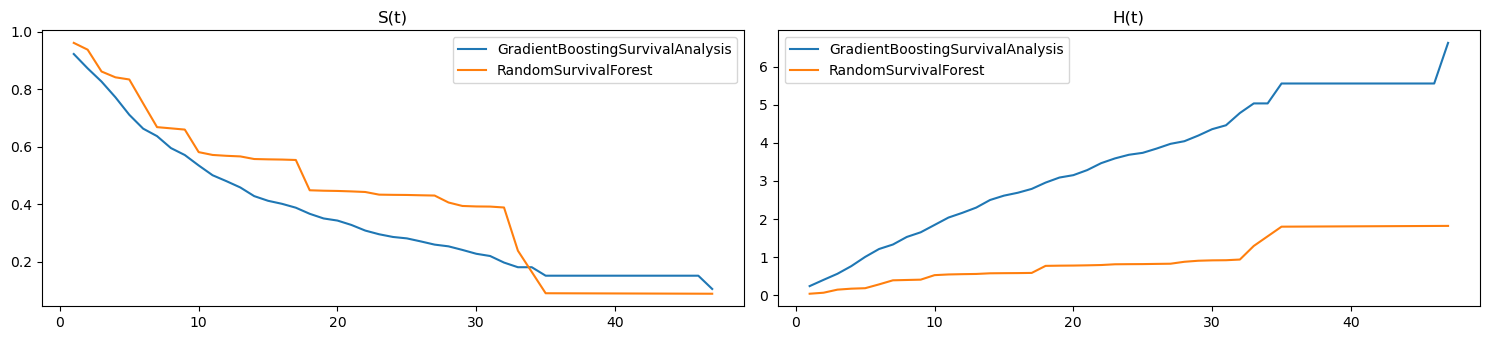

In [187]:
fig, ax = plt.subplots(1, 2, figsize=(15, 3.5))

y_pred = gbs.predict_survival_function(X)[0]
s1 = pd.Series(y_pred.y, index=y_pred.x)

y_pred = rsf.predict_survival_function(X)[0]
s2 = pd.Series(y_pred.y, index=y_pred.x)

y_pred = gbs.predict_cumulative_hazard_function(X)[0]
s4 = pd.Series(y_pred.y, index=y_pred.x)

y_pred = rsf.predict_cumulative_hazard_function(X)[0]
s5 = pd.Series(y_pred.y, index=y_pred.x)

s1.plot(ax=ax[0], label='GradientBoostingSurvivalAnalysis')
s2.plot(ax=ax[0], label='RandomSurvivalForest')

s4.plot(ax=ax[1], label='GradientBoostingSurvivalAnalysis')
s5.plot(ax=ax[1], label='RandomSurvivalForest')

ax[0].set_title('S(t)')
ax[1].set_title('H(t)')

ax[0].legend()
ax[1].legend()

plt.tight_layout()

Here is a merged view.

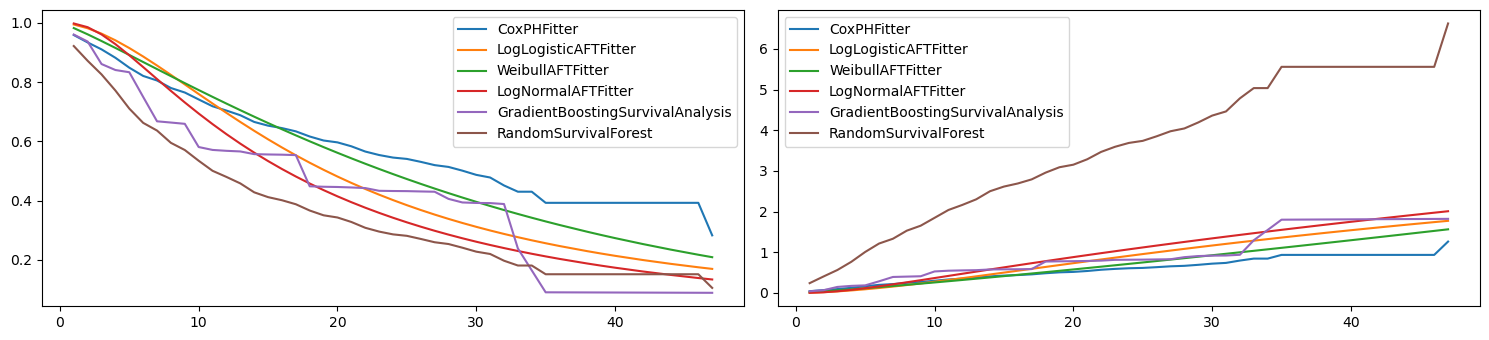

In [207]:
fig, ax = plt.subplots(1, 2, figsize=(15, 3.5))

as_series = lambda y_pred: pd.Series(y_pred.y, index=y_pred.x)

cph.lifelines_model.predict_survival_function(X)[0].plot(kind='line', label='CoxPHFitter', ax=ax[0])
lla.lifelines_model.predict_survival_function(X)[0].plot(kind='line', label='LogLogisticAFTFitter', ax=ax[0])
waf.lifelines_model.predict_survival_function(X)[0].plot(kind='line', label='WeibullAFTFitter', ax=ax[0])
lna.lifelines_model.predict_survival_function(X)[0].plot(kind='line', label='LogNormalAFTFitter', ax=ax[0])
as_series(rsf.predict_survival_function(X)[0]).plot(kind='line', label='GradientBoostingSurvivalAnalysis', ax=ax[0])
as_series(gbs.predict_survival_function(X)[0]).plot(kind='line', label='RandomSurvivalForest', ax=ax[0])

cph.lifelines_model.predict_cumulative_hazard(X)[0].plot(kind='line', label='CoxPHFitter', ax=ax[1])
lla.lifelines_model.predict_cumulative_hazard(X)[0].plot(kind='line', label='LogLogisticAFTFitter', ax=ax[1])
waf.lifelines_model.predict_cumulative_hazard(X)[0].plot(kind='line', label='WeibullAFTFitter', ax=ax[1])
lna.lifelines_model.predict_cumulative_hazard(X)[0].plot(kind='line', label='LogNormalAFTFitter', ax=ax[1])
as_series(rsf.predict_cumulative_hazard_function(X)[0]).plot(kind='line', label='GradientBoostingSurvivalAnalysis', ax=ax[1])
as_series(gbs.predict_cumulative_hazard_function(X)[0]).plot(kind='line', label='RandomSurvivalForest', ax=ax[1])

ax[0].legend()
ax[1].legend()

plt.tight_layout()